# Problem Statement: Term Deposit Marketing

Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. Term deposits are often seen as safer investments that have low risk but lower returns.

We are given the data coming from direct marketing efforts of a European banking institution (Client). The client is interested in developing a robust machine learning system that leverages information coming from the call center data. The marketing campaign involves making a phone call to a client's customer, often multiple times to ensure a product subscription, in this case a term deposit. All customer information that might reveal personal information is removed due to privacy concerns.

Ultimately, the client is looking for ways to improve the success rate for calls made to customers for any product that their clients offer. Towards this goal, the client is working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for their customers to make informed decisions.

## Data Description
The data is provided by the client and is a mix of categorical and numeric variables.

### Predictor Variables
1. age : age of customer (numeric)
2. job : type of job (categorical)
3. marital : marital status (categorical)
4. education (categorical)
5. default: has credit in default? (binary)
6. balance: average yearly balance, in euros (numeric)
7. housing: has a housing loan? (binary)
8. loan: has personal loan? (binary)
9. contact: contact communication type (categorical)
10. day: last contact day of the month (numeric)
11. month: last contact month of year (categorical)
12. duration: last contact duration, in seconds (numeric)
13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

### Response variable
- y: indicates whether the client's customer has subscribed to a term deposit (binary)

### Goals:
1. Predict whether the customer will subscribe to a term deposit
    - Success metric: Hit %81 or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.
2. The client is also interested in finding customers who are more likely to buy the investment product.
    - Determine the segment(s) of customers the client should prioritize.
3. What makes the customers buy?
    - Identify the feature(s) that the client should be focusing more on.

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np

# Visualizaton libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Create the dataframe from the given dataset
dataLocation = "../data/term-deposit-marketing-2020.csv"
df = pd.read_csv(dataLocation)
df.shape

(40000, 14)

The dataset has 40000 rows and 14 columns.

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


- Out of thirteen independent variables, eight are categorical and five are numerical.
- Out of 40000 rows and 14 variables, none of the variables have any null values.

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,40000.0,40.544600,9.641776,19.0,33.0,39.0,48.0,95.0
balance,40000.0,1274.277550,2903.769716,-8019.0,54.0,407.0,1319.0,102127.0
day,40000.0,16.017225,8.278127,1.0,8.0,17.0,21.0,31.0
duration,40000.0,254.824300,259.366498,0.0,100.0,175.0,313.0,4918.0
campaign,40000.0,2.882175,3.239051,1.0,1.0,2.0,3.0,63.0


- The age of contacted customers ranged from 19 years to 95 years. 75% of the contacted customers were of the age 48 years or younger.
- The variance in the account balance of contacted customers is quite hight, with the range being from -8019 to 102127. 75% of the contacted customers had account balance less than 1319.
- The day column represents the day of the month on which contact was made. Contacts were uniformly made throughout the month.
- The call duration lasted anywhere between 0 seconds (dropped calls?) to 4918 seconds. The min and max values may corresponds to an anomaly in the call duration.
- 75% of the customers were called 3 times or less. The maximum number that a particular customer was called is 63.

# Exploratory Data Analysis
In this section, we will first examine the *categorical variables* from the dataset. While analyzing, we will first conduct a univariate analysis and examine the distribution of the variable. This will be followed by analysis against the target variable. Here we are interested in knowing (and predicting) the types of customers that are more likely to subscribe to a term deposit. Hence, we will examine the proportion of customers under each level of each category that subscribed to the term deposit.

After that, we will start examining the numerical veriables with a similar work flow. We will first analyze the univariate distribution of each variable followed by analysis against the target variable.

## Categorical variables

In [6]:
def category_count_plot(df:pd, variable:str, title:str="", labels=True):
    '''
    returns a count plot of the variable with annotated percentages for each level of the category

    arguments: 
    1) dataframe: pandas dataframe containing the variable of interest
    2) variable name (string) for which the countplot is to be made
    3) plot title (optional)
    4) labels (bool) defines whether to annotate percentages for each level of the category.
    
    '''
    ax = sns.countplot(x=df[variable],
                       order=df[variable].value_counts(ascending=False).index);
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    
    if labels:
        abs_values = np.round(df[variable].value_counts(ascending=False).values/len(df[variable])*100, 2)
        ax.bar_label(container=ax.containers[0], labels=abs_values)
    ax.set_title(title)
    return ax


def yes_proportion_by_category_level(df:pd, variable:str):
    """
    prints the proportion of the contacted customers that subscribed to a term deposit for each level of the variable supplied in arguments
    
    arguments:
    1) dataframe: pandas dataframe containing the variable of interest
    2) variable: the name of the variable of interest
    """
    print('\nProportion of customers that subscribed to a term deposit - by' ,f"{variable}")
    for level in df[variable].unique():
        df_category = df.loc[df[variable]==level]
        yes = len(df_category.loc[df_category['y']=='yes'])
        no = len(df_category.loc[df_category['y']=='no'])
        yes_prop = round((yes/len(df_category))*100,2)
        print(f'{level}: {yes_prop}%')

/tmp/ipykernel_18810/1054183463.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


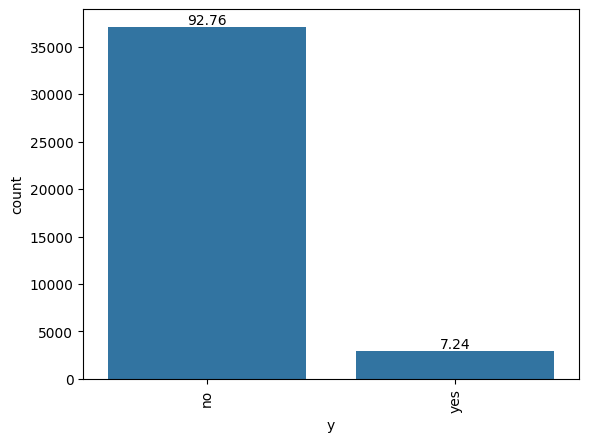

In [7]:
ax = category_count_plot(df, 'y')
plt.show()

##### The data is highly imbalanced. The proportion of contacted customers that subscribed to term-deposit (label=yes) was 7.24% whereas 92.76% of the contacted customers did not subscribe to term deposits.

/tmp/ipykernel_18810/1054183463.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


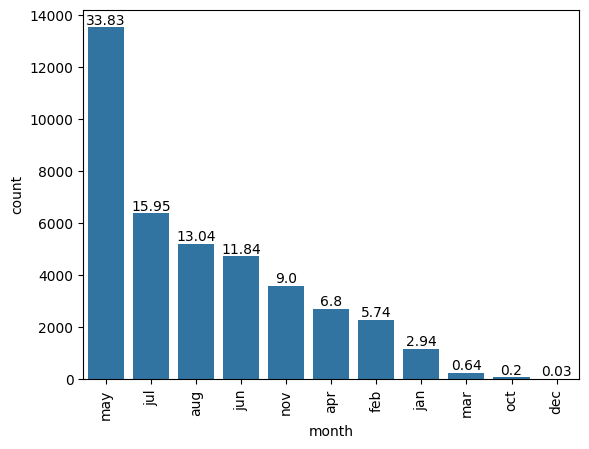


Proportion of customers that subscribed to a term deposit - by month
may: 5.85%
jun: 6.21%
jul: 6.02%
aug: 5.52%
oct: 61.25%
nov: 6.11%
dec: 7.69%
jan: 3.23%
feb: 11.11%
mar: 48.45%
apr: 16.59%


In [8]:
category_count_plot(df, 'month')
plt.show()
yes_proportion_by_category_level(df, 'month')

- Over third of customers were contacted during the month of May followed by July (15.95%), August (13.04%), and June (11.84%).
- During March, October, and December, least calls were made. - Combined, these three months accounted for less than 1% of the total calls made.
- In general, the trend shows that less calls are made in the first and the last quarter of the year compared to the second and third quarter.
- October and March months showed the highest conversion rate though the calls made during these months were among the least.
- Among first five months by number of customers contacted, June (6.21%) month showed the highest conversion rate followed by November (6.11%).

/tmp/ipykernel_18810/1054183463.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


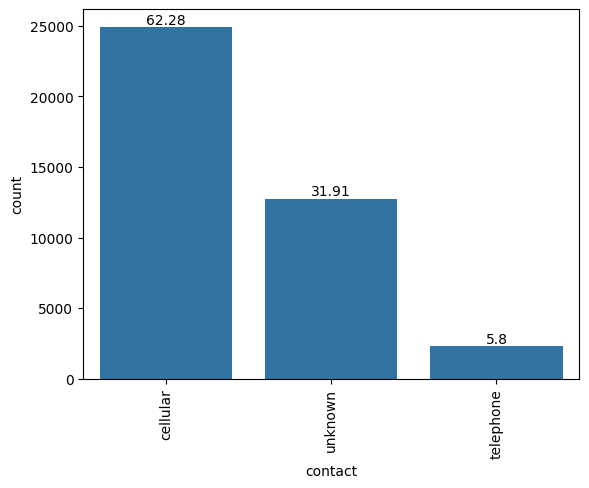


Proportion of customers that subscribed to a term deposit - by contact
unknown: 3.89%
cellular: 8.96%
telephone: 7.15%


In [9]:
category_count_plot(df, 'contact')
plt.show()
yes_proportion_by_category_level(df, 'contact')

- Customers were contacted on their cellular phones most of the times (62.28%).
- Around 6% of the customers were called on telephones.
- Among the customers called on cellular phone, about 9% subscribed to a term deposit followed by 7.1% of the customers contacted over telephone.
- **NOTE:** The numbers for these two categories might be more since for about third of the total customers, mode of contact is unknown.

/tmp/ipykernel_18810/1054183463.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


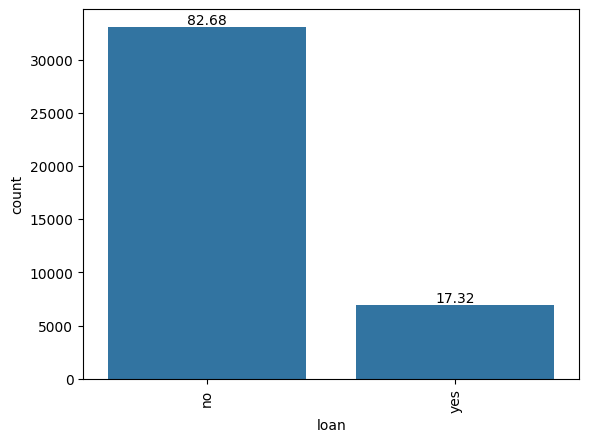


Proportion of customers that subscribed to a term deposit - by loan
no: 7.61%
yes: 5.48%


In [10]:
category_count_plot(df, 'loan')
plt.show()
yes_proportion_by_category_level(df, 'loan')

##### Majority of the contacted customers did not have an active loan. Only 17.5% of the customers had an ongoing active loan.
- Customers having no loan showed better conversion rate (7.61%) than those having active loans (5.48%).

/tmp/ipykernel_18810/1054183463.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


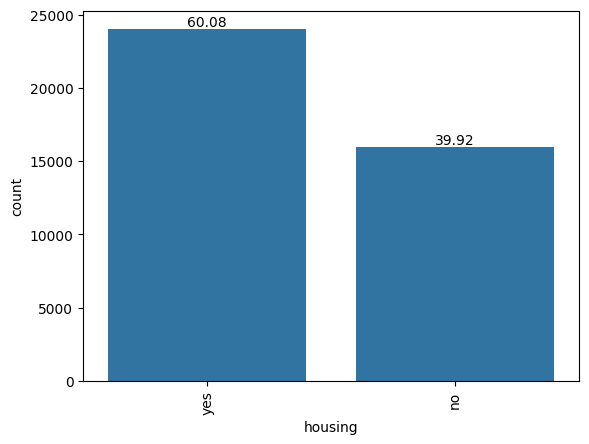


Proportion of customers that subscribed to a term deposit - by housing
yes: 6.09%
no: 8.97%


In [11]:
category_count_plot(df, 'housing')
plt.show()
yes_proportion_by_category_level(df, 'housing')

##### Over 60% of the contacted custoemrs had a house of their own
- Customers not having own housing were more likely to subscribe to a term deposit as compared to those having their own housing.

/tmp/ipykernel_18810/1054183463.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


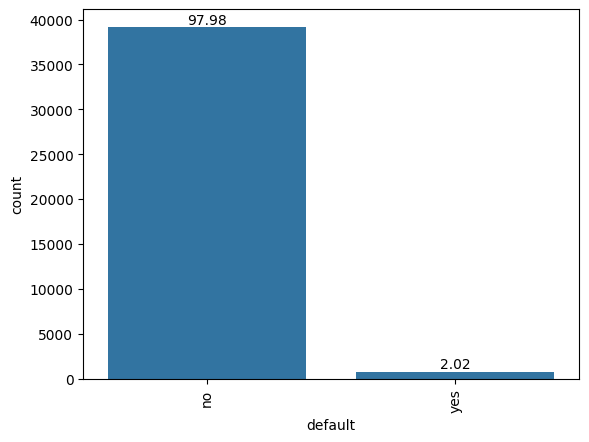


Proportion of customers that subscribed to a term deposit - by default
no: 7.26%
yes: 6.06%


In [12]:
category_count_plot(df, 'default')
plt.show()
yes_proportion_by_category_level(df, 'default')

##### Very few (2%) of the contacted customers had ever defauted on a loan.
- Customers who had defaulted on a loan were less likely to subscribe to a term deposit

/tmp/ipykernel_18810/1054183463.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


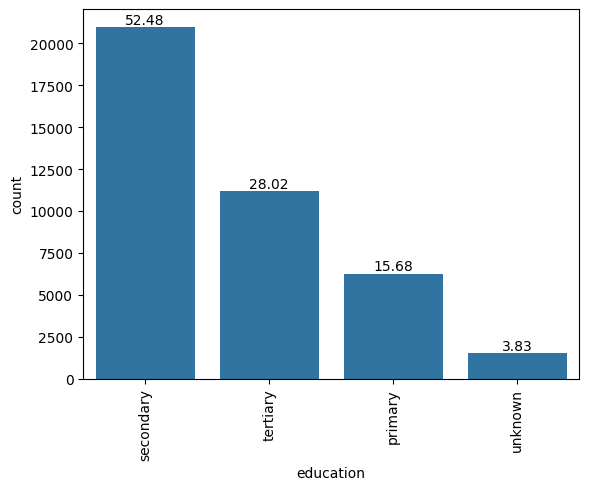


Proportion of customers that subscribed to a term deposit - by education
tertiary: 9.18%
secondary: 6.75%
unknown: 6.27%
primary: 5.63%


In [13]:
category_count_plot(df, 'education')
plt.show()
yes_proportion_by_category_level(df, 'education')

- More than half of the contacted customers had completed secondary education.
- Followed by 28% of the contacted customers who completed tertiary education.
- Note that for around 4% of the contacted customers, the education level was not known.
- Customers who had completed tertiary education were most likely to subscribe to a term deposit followed by the ones who had completed secondary education.

/tmp/ipykernel_18810/1054183463.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


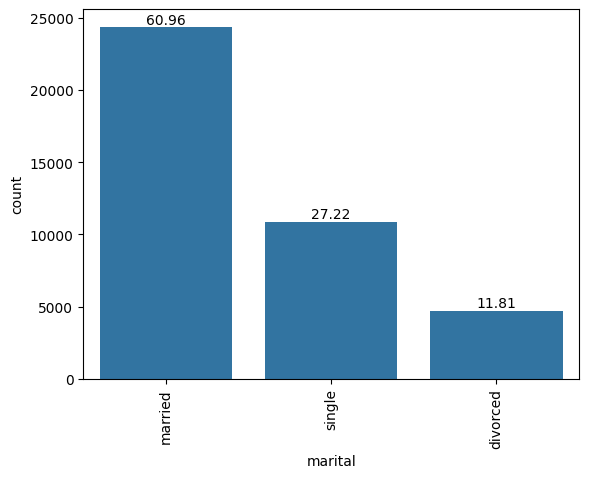


Proportion of customers that subscribed to a term deposit - by marital
married: 6.06%
single: 9.43%
divorced: 8.28%


In [14]:
category_count_plot(df, 'marital')
plt.show()
yes_proportion_by_category_level(df, 'marital')

- Over 60% of the contacted customers were married and over 27% were single.
- Few (11.81%) of the contacted customers were divorced.
- Single and divorced customers were more likely to suscribe to a term deposit than the married customers.

/tmp/ipykernel_18810/1054183463.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


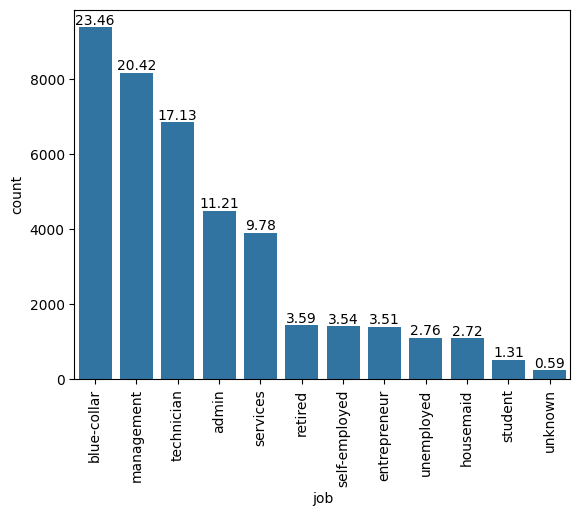


Proportion of customers that subscribed to a term deposit - by job
management: 8.28%
technician: 7.25%
entrepreneur: 6.26%
blue-collar: 5.7%
unknown: 7.23%
retired: 10.51%
admin: 7.83%
services: 6.09%
self-employed: 7.92%
unemployed: 8.7%
housemaid: 4.88%
student: 15.65%


In [15]:
category_count_plot(df, 'job')
plt.show()
yes_proportion_by_category_level(df, 'job')

- Most customer that were contacted were employed.
- Except for about 12% of customers who were either self employed, entrepreneurs, uneployed or students.
- Over 80% of the of the contacted customers had a job that was either blue-collar, management, technician, admin or services job.
- For some (0.59%) customers, the employment status was not known.
- Students and retred professional were most likely to subscribe to a term deposit followed by management professionals and unemployed individuals
- Housemaids, service professionals and blue collared workers were least likely to subscribe to a term deposit

/tmp/ipykernel_18810/1054183463.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


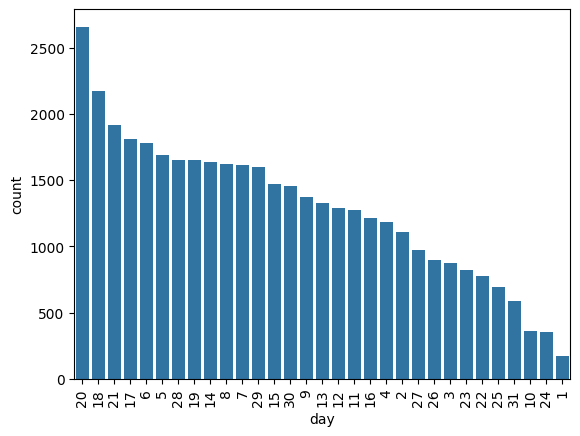


Proportion of customers that subscribed to a term deposit - by day
5: 6.68%
6: 6.19%
7: 4.96%
8: 6.3%
9: 5.24%
12: 8.07%
13: 8.83%
14: 7.03%
15: 8.38%
16: 7.9%
19: 4.42%
20: 5.76%
21: 7.26%
23: 7.17%
26: 6.82%
27: 8.62%
28: 3.7%
29: 3.06%
30: 15.37%
2: 9.38%
3: 9.15%
4: 9.89%
11: 6.68%
17: 6.35%
18: 7.59%
24: 9.09%
25: 10.36%
1: 22.73%
10: 12.36%
22: 10.35%
31: 4.4%


In [16]:
category_count_plot(df, 'day', labels=False)
plt.show()
yes_proportion_by_category_level(df, 'day')

- Customers contacted on 30th of any month were most likely to subscribe to a term deposit.
- A large number of customers were contacted on 20th and 18th day of the month, however the conversion rates on these days were not a lot.

# Numerical variables

In [17]:
def numerical_distribution(df, variable, univariate=True):
    fig, axs = plt.subplots(3,1, sharex=True)
    sns.boxplot(data=df, x=variable, showmeans=True, ax=axs[0])
    sns.histplot(data=df, x=variable, kde=True, ax=axs[1])
    sns.ecdfplot(data=df, x=variable, ax=axs[2])
    if univariate: 
        fig.suptitle(f'Distribution of contacted customers by {variable}')
    else: fig.suptitle(f'Distribution of customers subscribing to term deposit by {variable}')
    plt.show()

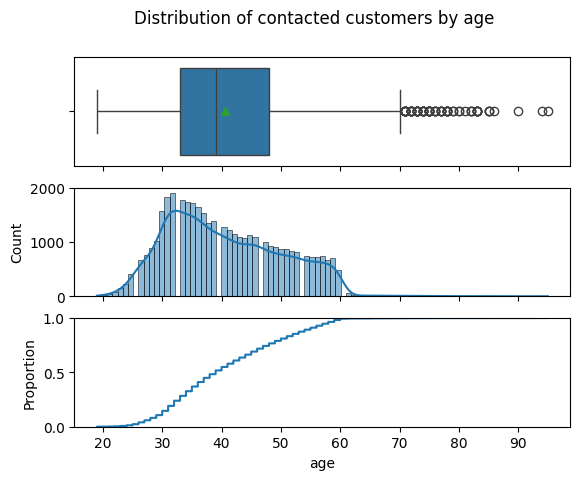

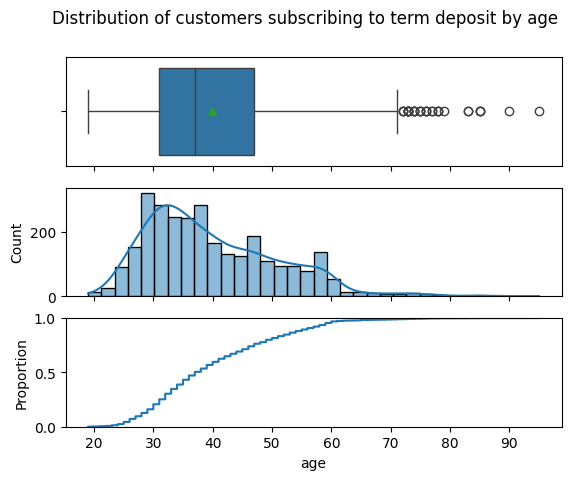

In [18]:
numerical_distribution(df, 'age')
numerical_distribution(df.loc[df['y']=='yes'], 'age', False)

- Half of the contacted customers were less than 40 years old the majority of the contacted customers were less than 60 years old.
- There were some contacted customers who were older than 60 years and could be tagged as outliers
- Younger customers showed more willingness to subscribe to a term deposit compared to older customers

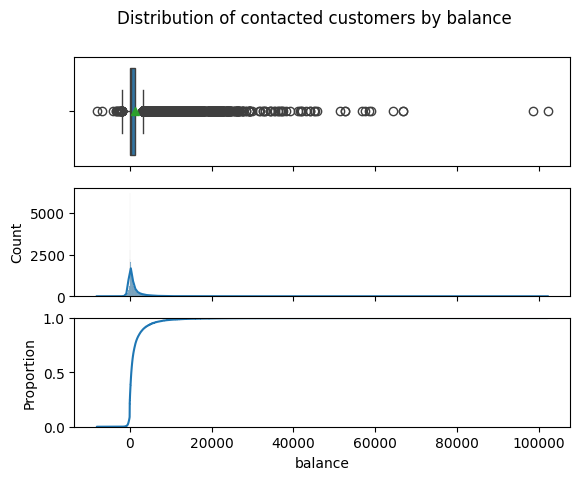

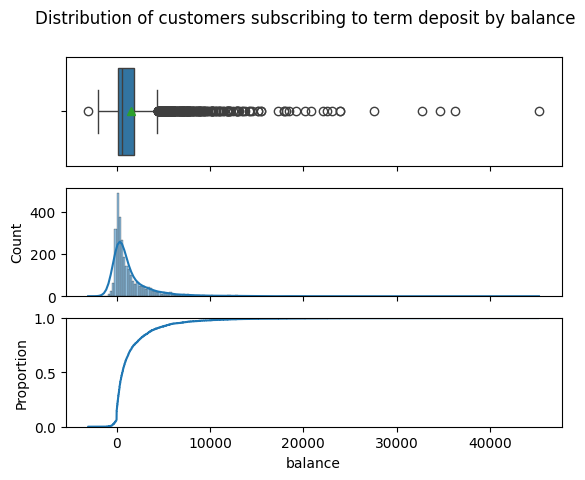

In [19]:
numerical_distribution(df, 'balance')
numerical_distribution(df.loc[df['y']=='yes'], 'balance', False)

- Most of the contacted customers had bank balance lower than 10,000 - as a result customers subscribing to term deposit also had lower bank balance
- Outliers were found in the bank balance on both ends. Some customers had negative bank balance and some cusomers had significantly higher bank balance compared to the rest of the contacted customers

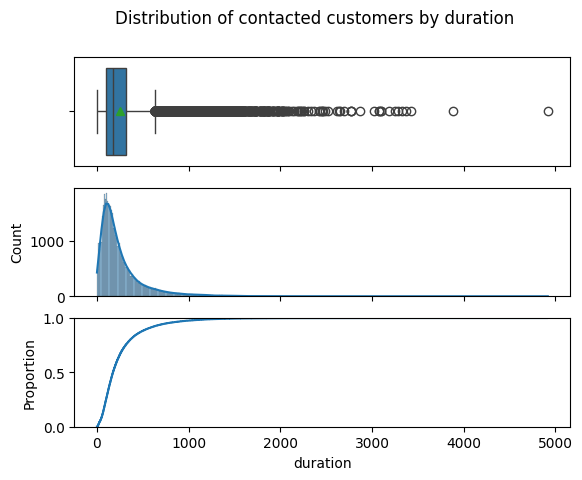

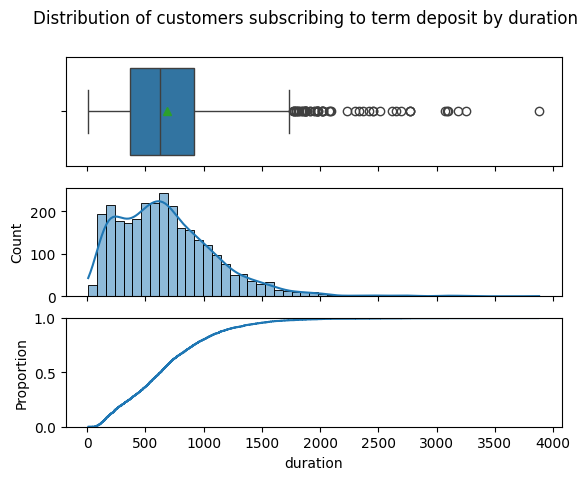

In [20]:
numerical_distribution(df, 'duration')
numerical_distribution(df.loc[df['y']=='yes'], 'duration', False)

- Customers for whom the call duration lasted for between 100 to 700 seconds showed most willingness to subscribe to a term deposit

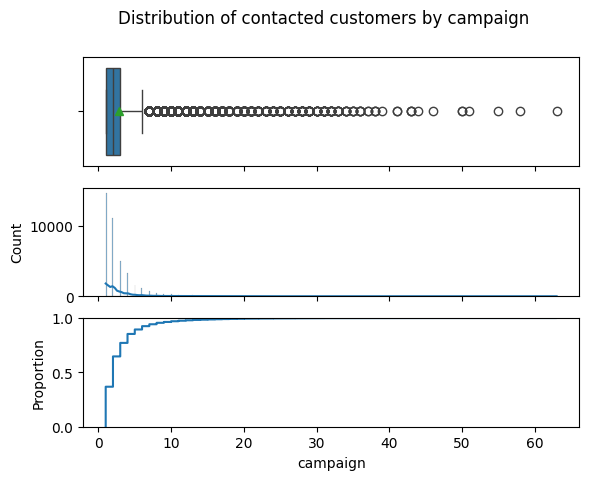

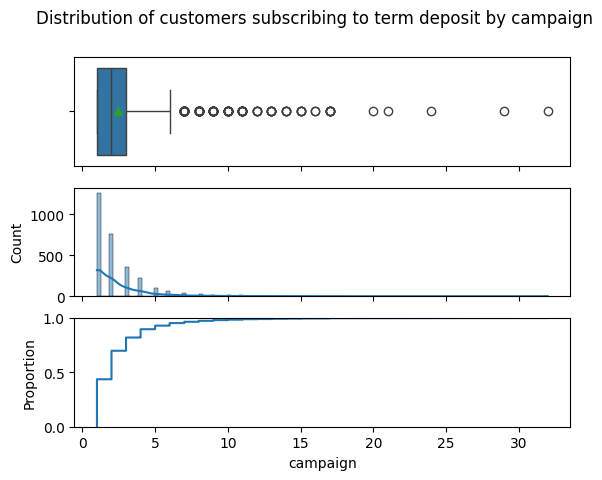

In [21]:
numerical_distribution(df, 'campaign')
numerical_distribution(df.loc[df['y']=='yes'], 'campaign', False)

Most customers were contacted either once or twice. These customers were more likely to subscribe to a term deposits compared to the ones who were called more often.

# Multivariate Analysis

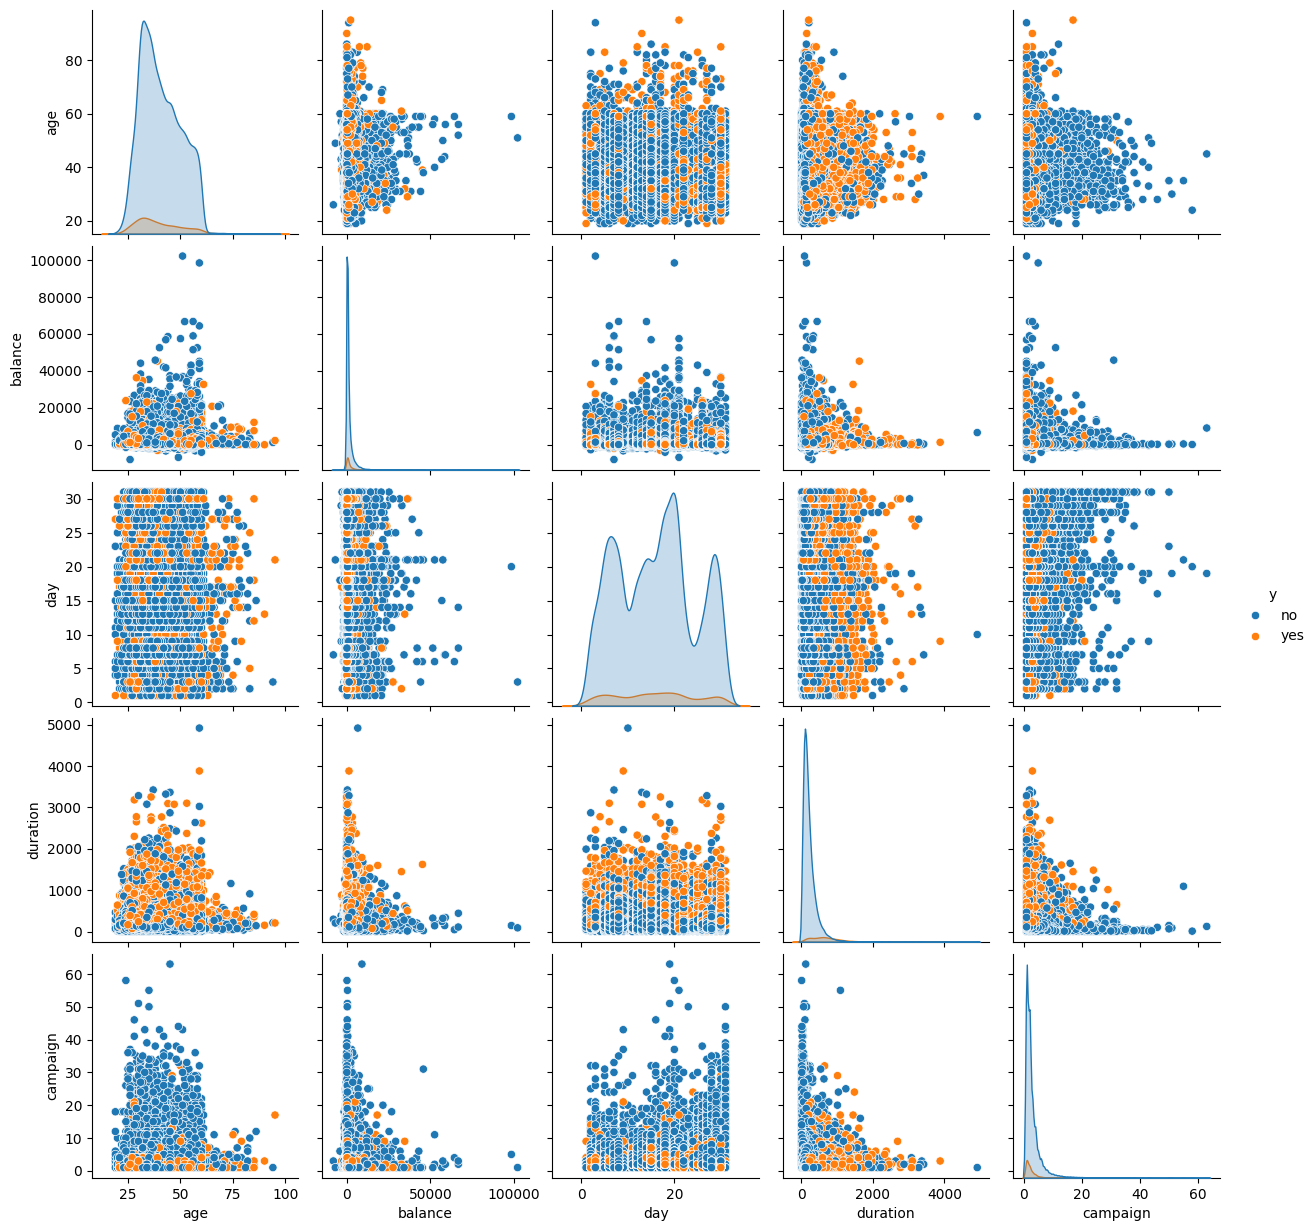

In [22]:
sns.pairplot(df, hue='y')

There was no clear distinction between the customers who subscribed to a term deposit vs customers who did not.

<Axes: >

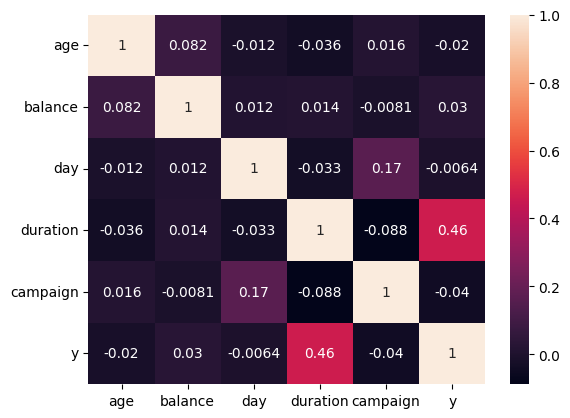

In [23]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['y'] = le.fit_transform(df['y'])
sns.heatmap(df.select_dtypes(exclude=['object']).corr(), annot=True)

The call duration and the campaign variables showed most correlation with the target variable. Other variables were weakly correlated.

# Data Preprocessing

In [24]:
# Set the type of categorical variables
for categoricalVariable in ['job', 'marital', 'education', 'default',
                        'housing', 'loan', 'contact', 'month', 'y']:
    df[categoricalVariable] = df[categoricalVariable].astype('category')


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        40000 non-null  int64   
 1   job        40000 non-null  category
 2   marital    40000 non-null  category
 3   education  40000 non-null  category
 4   default    40000 non-null  category
 5   balance    40000 non-null  int64   
 6   housing    40000 non-null  category
 7   loan       40000 non-null  category
 8   contact    40000 non-null  category
 9   day        40000 non-null  int64   
 10  month      40000 non-null  category
 11  duration   40000 non-null  int64   
 12  campaign   40000 non-null  int64   
 13  y          40000 non-null  category
dtypes: category(9), int64(5)
memory usage: 1.9 MB


## Outlier Treatment

In [26]:
def get_outlier_count(df, variable):
    '''
    Return the count of outliers for the variable from the data supplied in arguments.
    '''
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3 - q1
    
    lowerWhisker = q1 - 1.5 * iqr
    upperWhisker = q3 + 1.5 * iqr
    
    return len(df.loc[(df[variable]<lowerWhisker) | (df[variable]>upperWhisker) ])
    

numericalVariables = ['age','balance','duration','campaign']
for numericalVariable in numericalVariables:
    outlierCount = get_outlier_count(df, numericalVariable)
    print(numericalVariable, outlierCount)

age 79
balance 4280
duration 3000
campaign 2992


Outliers were found in all numerical variables. We will treat the outliers using IQR method.

In [27]:
def ceil_floor_outliers(df, variable):
    """
    Return a dataframe after capping (ceil and floor to whiskers) outliers in numerical variables
    """
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3 - q1
    
    lowerWhisker = q1 - 1.5 * iqr
    upperWhisker = q3 + 1.5 * iqr
    
    df[variable] = np.clip(df[variable], lowerWhisker, upperWhisker) # limit the outliers to the upper/lower whisker values

    return df

In [28]:
numericalVariables = ['age', 'balance', 'duration', 'campaign']

In [29]:
for numericalVariable in numericalVariables:
    df = ceil_floor_outliers(df, numericalVariable)

# Check if the outliers are now treated
numericalVariables = ['age','balance','duration','campaign']
for numericalVariable in numericalVariables:
    outlierCount = get_outlier_count(df, numericalVariable)
    print(numericalVariable, outlierCount)

age 0
balance 0
duration 0
campaign 0


Outliers were successfully capped

In [30]:
# Deal with imbalanced data : Random undersampling

In [31]:
from imblearn.under_sampling import RandomUnderSampler

y = df['y']
le = LabelEncoder()

y = le.fit_transform(y)
X = df.drop('y', axis=1)

np.bincount(y)

array([37104,  2896])

As seen earlier, the target variable is highly imbalanced with very few customers subscribing to term deposits compared to the ones who did not. We will undersample the datapoints in which customers had not subscribed to the term deposit

In [32]:
rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(X, y)
np.bincount(y)

array([2896, 2896])

In [33]:
X_dummy = pd.get_dummies(X)

In [34]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_dummy, y,test_size=.2, random_state=121)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|███████████████████████████████████████████| 29/29 [00:03<00:00,  9.58it/s]

[LightGBM] [Info] Number of positive: 2309, number of negative: 2324
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 4633, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498381 -> initscore=-0.006475
[LightGBM] [Info] Start training from score -0.006475


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.82,0.82,0.82,0.82,0.08
AdaBoostClassifier,0.82,0.82,0.82,0.82,0.12
SVC,0.82,0.82,0.82,0.82,0.34
NuSVC,0.81,0.81,0.81,0.81,0.43
RandomForestClassifier,0.81,0.81,0.81,0.81,0.46
XGBClassifier,0.81,0.81,0.81,0.81,0.11
BernoulliNB,0.81,0.81,0.81,0.80,0.01
GaussianNB,0.80,0.80,0.80,0.80,0.01
LinearSVC,0.80,0.80,0.80,0.80,0.08


##### We can see that the LGBM, AdaBoost, and Support Vector performed the best. 
The dataset has a number of categorical features in addition to the numerical features. Hence for the interpretability and ability to deal with categorical variables natively without any additional encoding, we choose tree based model LGBM for further analysis and usage. This model achieves the required 81% accuracy without any hyperparameter tuning. 

[LightGBM] [Info] Number of positive: 2332, number of negative: 2301
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 4633, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503346 -> initscore=0.013382
[LightGBM] [Info] Start training from score 0.013382
0.8748921484037964
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       556
           1       0.91      0.85      0.88       603

    accuracy                           0.87      1159
   macro avg       0.88      0.88      0.87      1159
weighted avg       0.88      0.87      0.87      1159



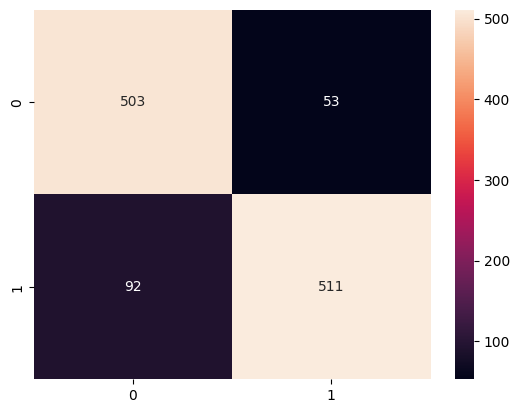

In [35]:
# Let's begin by retraining the model with train_test split without encoding the categorical variables
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2, random_state=131)

import lightgbm as lgbm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model = lgbm.LGBMClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt='')
print(classification_report(y_pred, y_test))

We notice that the accuracy is even better when the LGBM is trained without explicitely one-hot-encoding the categorical variables.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

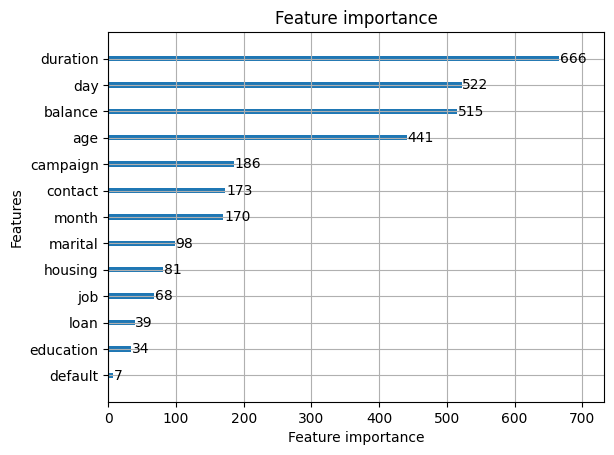

In [36]:
lgbm.plot_importance(model)

<Axes: >

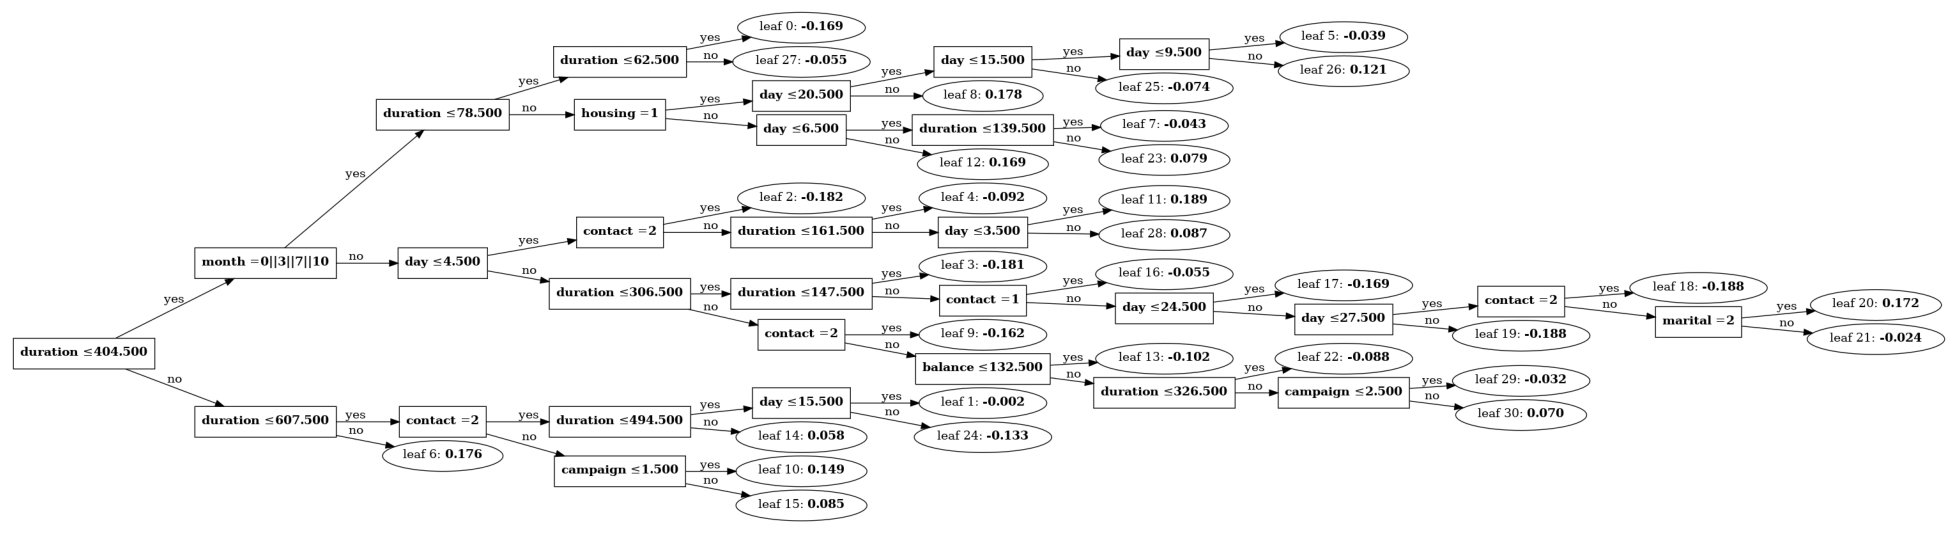

In [37]:
lgbm.plot_tree(model, figsize=(25,15))

# Cross Validation

In [38]:
from sklearn.model_selection import cross_val_score
model = lgbm.LGBMClassifier()
scores = cross_val_score(model, X_train, y_train, cv=5)

[LightGBM] [Info] Number of positive: 1865, number of negative: 1841
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 643
[LightGBM] [Info] Number of data points in the train set: 3706, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503238 -> initscore=0.012952
[LightGBM] [Info] Start training from score 0.012952
[LightGBM] [Info] Number of positive: 1865, number of negative: 1841
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 643
[LightGBM] [Info] Number of data points in the train set: 3706, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503238 -> initscore=0.012952
[LightGBM] [I

In [39]:
scores

array([0.84789644, 0.88457389, 0.87918015, 0.87257019, 0.89308855])

Thus we have verified that the trained model hits the required accuracy of 81% through 5-fold cross-validation. 



# Conclusion
In this project, we were given the data coming from direct marketing efforts of a European banking institution (Client). The client was interested in developing a robust machine learning system that leverages information coming from the call center data. The marketing campaign involved making a phone call to a client's customer, often multiple times to ensure a product subscription, in this case a term deposit. All customer information that might reveal personal information was removed due to privacy concerns. Ultimately, the client was looking for ways to improve the success rate for calls made to customers for any product that their clients offer. Towards this goal, this project provided a trained machine learning model to predict the success of each marketing call.

## Data
- The provided data had a mix of categorical and numerical features.
- The target variable was highly imbalanced since the proportion of the customers that subscribed to a term deposit was significantly less than those who did not. We used random undersampling approach to deal with theimbalanced data.
- Numerical veriables from the data set had outliers. These outliers were treated using IQR approach where outlying values were capped (ceil or floor) to the upper and lower whiskers respectively.

## Customer Segmentation
From the EDA, following points were evident about the customers who were most likely to subscribe to a term deposit.
- October and March months showed the highest conversion rate though the calls made during these months were among the least.
- Among first five months by number of customers contacted, June (6.21%) month showed the highest conversion rate followed by November (6.11%).
- Among the customers called on cellular phone, about 9% subscribed to a term deposit followed by 7.1% of the customers contacted over telephone.
- Customers having no loan showed better conversion rate (7.61%) than those having active loans (5.48%).
- Customers not having own housing were more likely to subscribe to a term deposit as compared to those having their own housing.
- Customers who had defaulted on a loan were less likely to subscribe to a term deposit
- Customers who had completed tertiary education were most likely to subscribe to a term deposit followed by the ones who had completed secondary education.
- Single and divorced customers were more likely to suscribe to a term deposit than the married customers.
- Students and retred professional were most likely to subscribe to a term deposit followed by management professionals and unemployed individuals
Housemaids, service professionals and blue collared workers were least likely to subscribe to a term deposit
- Customers contacted on 30th of any month were most likely to subscribe to a term deposit.
- Younger customers showed more willingness to subscribe to a term deposit compared to older customers
- There were some customers who subscribed to the term deposit in spite having a negative bank balance. This might be an anomaly in the data.
- Most customers were contacted either once or twice. These customers were more likely to subscribe to a term deposits compared to the ones who were called more often.

## Modeling
Several classification models were compared without any hyperparameter tuning. Since the dataset had categorical variables, it was important to select a model that can offer interpretability, speed and accuracy while dealing with categorical variables. 

AdaBoost, LightGBM, and Support Vector Machine based classifiers were found to be the best performing models. Among those, LightGBM was selected for further analysis and training given its intepretability, speed, accuracy and ability to deal with categorical variables natively. The model was evaluated using train-test split and 5-fold cross validation approach and found to hit the required accuracy of 81% in every fold as well as test data.

## Feature Importance
From the analysis of the trained model, it was clear that the most important features that the client should focus on are the following:
- duration
- day
- balance
- age

The `default` feature was the least significant feature.